In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

In [3]:
# Read the data
retail = pd.read_csv('Online+Retail.csv', sep = ',', encoding = 'iso-8859-1', header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [7]:
retail['InvoiceDate'].head(2)

0    01-12-2010 08:26
1    01-12-2010 08:26
Name: InvoiceDate, dtype: object

In [8]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
# parse (Data parsing is a method where one string of data gets converted into a different type of data.)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = '%d-%m-%Y %H:%M')

In [11]:
# the data set is at the granularity of order level. So, it doesn’t make much sense to do missing value imputation because it would be very difficult to predict the individual missing details of individual orders. Hence, you have to remove the entries with the missing values.
# Dropping the na cells
order_wise = retail.dropna()

#### RFM analysis

In RFM analysis, you look at the recency, frequency and the monetary scores of all the customers for segmentation.

 -Recency: It measures how recently you visited the store or made a purchase

 -Frequency: It measures the frequency of the transactions the customers made

 -Monetary: It measures how much the customer spent on purchases he/she made

In [12]:
# Let’s start with creating customer-wise data. 
# We begin with the computation of M of the RFM, that is the total monetary value of the purchases made 
# by each customer.
# Create a vector named Amount, which creates the total monetary value of each order, and append the 
# column to your data set.

# RFM implementation
amount = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ['Amount'])

# merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

In [13]:
# sorting the dataset in order of customer ID 
# creating a new vector 'monetory' - which give aggregate purchase amount for each customer.
# Monetory Function
monetory = order_wise.groupby("CustomerID").Amount.sum()
monetory = monetory.reset_index()

In [14]:
monetory.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


The above dataframe monetory is the M of the RFM analysis.

Now, Lets focus on the F of the RFM framework i.e frequecy of purchases of each customer.
 - for this we need to count the number of unique Invoice Numbers for each CustomerID.

In [15]:
# Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

k = frequency.groupby('CustomerID').InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ['CustomerID', 'Frequency']

In [16]:
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [17]:
# creating a master dataset
master = monetory.merge(k, on='CustomerID', how='inner')
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


###### Thus, the data frame master contains both the monetary and the frequency attributes corresponding to each customer IDs. Now, you have to turn your attention towards the computation of the recency, i.e. for how long a customer has not visited the online store.

In [19]:
# Generaring recency function
recency = order_wise[['CustomerID', 'InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days = 1)
recency['diff'] = maximum - recency.InvoiceDate

# Dateframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ['CustomerID', 'Recency']
df.head()

C:\Users\sumee\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [20]:
# combining all recency, frequency and monetory parameters
RFM = k.merge(monetory, on='CustomerID')
RFM = RFM.merge(df, on='CustomerID')
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


Thus, we have obtained the RFM data corresponding to each customer. These 3 attributes will form the basis, depending on which the customers will be segregated into different clusters.

###### let’s treat the data set for outliers. One way to do it is by eliminating all the data points which fall outside the 1.5 times the IQR of the 1st and the 3rd quartile.

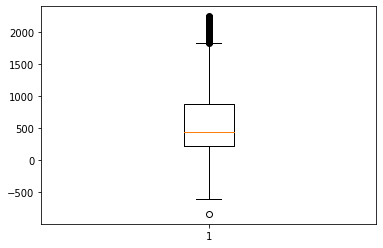

In [23]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

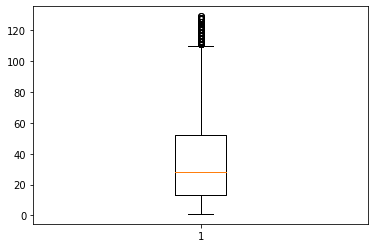

In [24]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

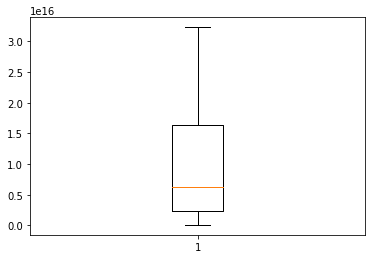

In [25]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [27]:
RFM.head(20)

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00
6,12353.0,4,89.00,204 days 19:03:00
7,12354.0,58,1079.40,232 days 23:39:00
8,12355.0,13,459.40,214 days 23:01:00
11,12358.0,19,1168.06,2 days 02:24:00
14,12361.0,10,189.90,287 days 22:59:00


In [28]:
#standardise all parameters
RFM_norml = RFM.drop('CustomerID', axis = 1)
RFM_norml.Recency = RFM_norml.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit_transform(RFM_norml)

array([[-1.18918148, -1.26697298,  1.98761705],
       [-0.11530753,  2.89191813, -0.36990472],
       [ 1.43995818,  2.80007376, -0.89588567],
       ...,
       [-0.89294039, -0.84905676,  1.53677623],
       [-1.0040308 , -1.079952  ,  0.62570208],
       [-0.78184998, -0.85831294, -0.99920336]])

So, the data preparation is now complete. So, let’s reiterate the steps involved in data preparation:

 - Missing value treatment

 - Transforming data from Order-level to Customer-level

 - Calculation of RFM values

 - Outlier treatment

 - Standardisation of data

In [31]:
# creating clusters on cleaned data
classmodel_clus = KMeans(n_clusters=3, init='random', n_init=10, max_iter=50).fit(RFM_norml)

### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

 - if the value is between {0.01, ..., 0.3}, the data is regularly spaced.
 - if the value is around 0.5, it is random.
 - if the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [32]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H   
    

In [33]:
hopkins(RFM_norml)

0.854565972584015

## K-Means with some K

In [34]:
# KMeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norml)

KMeans(max_iter=50, n_clusters=5)

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [35]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norml)
    sse_.append([k, silhouette_score(RFM_norml, kmeans.labels_)])

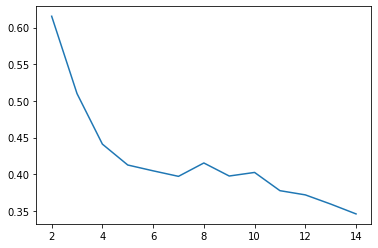

In [36]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

## Sum of Squared Distances

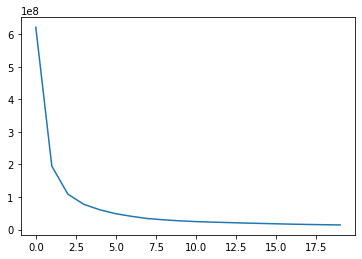

In [37]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1, 21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norml)
    ssd.append(model_clus.inertia_)
    
plt.plot(ssd)

In [38]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [39]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,1497.765209,66.469453,58.717042
1,1,240.423393,23.160221,57.839779
2,2,988.648747,53.098434,69.595078
3,3,194.608258,16.486091,267.083455
4,4,581.153515,38.478205,94.138462


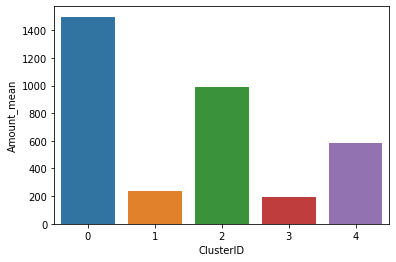

In [40]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

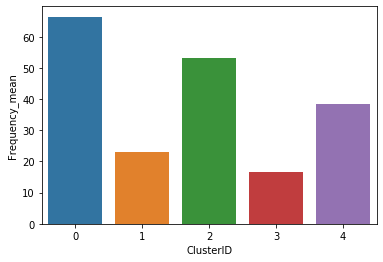

In [41]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

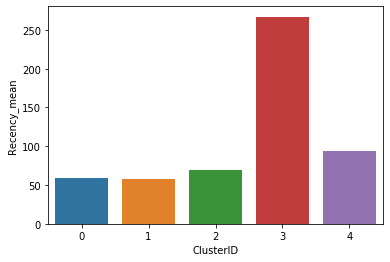

In [42]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

As per the analysis, cluster '0' was the best customer segment from the store’s point of view. These customers make a purchase for a higher amount, more frequently, and these customers had visited the site recently. Thus, the store may offer them a reward or loyalty points or some privileged status, to keep them attracted and coming back to the store.

On the other hand, cluster 3 had the worst customers from the store’s point of view. Thus, the store may decide to focus more on this group. Similarly, in cluster 1, the customers had favourable features in terms of the purchase amount and recency; however, these have low frequency. Thus, if the store can re-design its incentive strategy and entice these customers into making a purchase more frequently, they could turn profitable for the store.